# Topic Model Evaluation: Women with ADHD vs Women without ADHD

1. **Separate Models Comparison** (JSD between independently trained models)
   - Tests: "How differently do groups structure their language?"
   - Method: Compare topic distributions from separate BERTopic models
   - Statistical tests: Fisher's p-value, Jensen-Shannon Divergence, Bootstrap confidence intervals

2. **Combined Model Analysis** (Permutation test with shared topic space)
   - Tests: "How differently do groups use shared linguistic themes?"
   - Method: Single BERTopic model on all data, permutation test for group differences
   - Statistical test: Permutation test with proper null hypothesis

In [1]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from bertopic import BERTopic
from collections import Counter
from scipy.stats import fisher_exact
from scipy.spatial.distance import jensenshannon
from sentence_transformers import SentenceTransformer
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Setup & Data Loading

In [2]:
topic_df = pd.read_pickle("../../data/adhd-beliefs-pt/adhd-beliefs-pt-embeddings-serafim-bertopic.pkl")
topic_df.head()

,datetime,sex,adhd_diagnosis,age,education,occupation,dialect,forgetting_objects,forgetting_responsabilities,emotion_management,...,need_fast_talk_interest,need_fast_talk_information,speaking_before_thinking,something_to_add,something_to_add_timid,something_to_add_impulsive,question,response,response_embedding,group
1,2025-03-30T16:29:47+02:00,Feminino,Não tenho,22,Licenciatura,Estudante,Português de Portugal,3,3,4,...,1,1,3,4,4,2,special_interest,"Adoro cozinhar, porque sinto que é a forma ide...","[-0.0066892994, -0.008711162, 0.020823173, -0....",Female_noADHD
3,2025-03-31T12:08:00+02:00,Feminino,Não tenho,23,Mestrado,Trabalhador-estudante,Português de Portugal,2,1,4,...,1,1,4,4,4,2,special_interest,Gosto de ver séries porque relatam relações sa...,"[0.011201557, -0.016555935, 0.05544479, 0.0285...",Female_noADHD
8,2025-03-31T12:55:43+02:00,Feminino,Não tenho,19,Licenciatura,Estudante,Português de Portugal,3,2,2,...,4,4,2,4,3,3,special_interest,Campos de ferias. Temos que criar o campo todo...,"[-0.010825635, -0.023888972, -0.013832389, -0....",Female_noADHD
14,2025-03-31T13:54:40+02:00,Feminino,Não tenho,25,Mestrado,Trabalhador,Português de Portugal,4,3,4,...,2,3,3,5,4,4,special_interest,"Taylor Swift, amo o seu liricismo e a maneira ...","[-0.029966783, -0.030345816, 0.014844258, 0.01...",Female_noADHD
15,2025-03-31T13:58:15+02:00,Feminino,Suspeito que tenho,25,Licenciatura,Trabalhador,Português de Portugal,4,2,5,...,2,2,3,5,5,3,special_interest,Historia da arte \nÉ só tão interessante. Para...,"[-0.026616443, -0.021927392, 0.014119624, 0.01...",Female_noADHD


## Helper Functions

In [3]:
def topic_word_weight_matrix(topic_model, top_n=30):
    """Extract topic-word weights for alignment"""
    topics_info = topic_model.get_topics()
    topic_ids = [tid for tid in topics_info.keys() if tid != -1]
    t2weights = {}
    for tid in topic_ids:
        pairs = topics_info[tid][:top_n]
        t2weights[tid] = dict(pairs)
    return t2weights, topic_ids

In [4]:
def build_union_vocab(t2w_A, t2w_B):
    """Build union vocabulary from two topic models"""
    vocab = sorted(set().union(*[set(d.keys()) for d in t2w_A.values()],
                               *[set(d.keys()) for d in t2w_B.values()]))
    index = {w:i for i,w in enumerate(vocab)}
    return vocab, index

In [5]:
def topics_to_matrix(t2w, topic_ids, index):
    """Convert topic-word weights to normalized matrix"""
    K, V = len(topic_ids), len(index)
    M = np.zeros((K, V), dtype=float)
    for r, tid in enumerate(topic_ids):
        for w, wt in t2w[tid].items():
            j = index.get(w)
            if j is not None:
                M[r, j] = wt
    norms = np.linalg.norm(M, axis=1, keepdims=True) + 1e-12
    return M / norms

In [6]:
def align_topics_by_cosine(model_A, model_B, top_n=30):
    """Align topics between two models using cosine similarity"""
    t2w_A, tids_A = topic_word_weight_matrix(model_A, top_n=top_n)
    t2w_B, tids_B = topic_word_weight_matrix(model_B, top_n=top_n)
    vocab, index = build_union_vocab(t2w_A, t2w_B)
    A = topics_to_matrix(t2w_A, tids_A, index)
    B = topics_to_matrix(t2w_B, tids_B, index)
    sim = cosine_similarity(A, B)
    cost = 1.0 - sim
    row_ind, col_ind = linear_sum_assignment(cost)
    matches = [(tids_A[i], tids_B[j], float(sim[i, j])) for i, j in zip(row_ind, col_ind)]
    return tids_A, tids_B, matches, sim

In [7]:
def counts_per_topic(topic_ids_for_docs):
    """Count documents per topic"""
    c = Counter([t for t in topic_ids_for_docs if t != -1])
    return c

In [8]:
def js_divergence(p, q, base=2):
    """Calculate Jensen-Shannon Divergence between two distributions"""
    p = np.asarray(p, dtype=float); q = np.asarray(q, dtype=float)
    eps = 1e-12
    p = (p + eps) / (p.sum() + eps * len(p))
    q = (q + eps) / (q.sum() + eps * len(q))
    m = 0.5*(p+q)
    def kl(a,b):
        mask = a > 0
        return np.sum(a[mask]*np.log(a[mask]/b[mask]))
    jsd_nat = 0.5*kl(p,m) + 0.5*kl(q,m)
    return jsd_nat/np.log(base)

In [9]:
def complete_corrected_analysis(A_vec, B_vec, group_names=("ADHD", "non-ADHD")):
    """
    Statistically appropriate analysis for topic distribution data
    """
    
    print("="*60)
    print(f"CORRECTED TOPIC ANALYSIS: {group_names[0]} vs {group_names[1]}")
    print("="*60)
    
    # 1. EFFECT SIZE (Always valid)
    jsd = jensenshannon(A_vec / A_vec.sum(), B_vec / B_vec.sum(), base=2)
    print(f"\n📊 EFFECT SIZE:")
    print(f"Jensen-Shannon Divergence: {jsd:.3f}")
    
    if jsd < 0.1:
        effect_size = "Very small effect"
    elif jsd < 0.3:
        effect_size = "Small to moderate effect"
    elif jsd < 0.5:
        effect_size = "Large effect"
    else:
        effect_size = "Very large effect"
    print(f"Interpretation: {effect_size}")
    
    # 2. DATA STRUCTURE ANALYSIS
    A_nonzero = np.sum(A_vec > 0)
    B_nonzero = np.sum(B_vec > 0)
    overlap = np.sum((A_vec > 0) & (B_vec > 0))
    
    print(f"\n📈 DATA STRUCTURE:")
    print(f"{group_names[0]} uses {A_nonzero} topics")
    print(f"{group_names[1]} uses {B_nonzero} topics") 
    print(f"Overlapping topics: {overlap}")
    print(f"Total documents: {group_names[0]}={A_vec.sum()}, {group_names[1]}={B_vec.sum()}")
    
    # 3. STATISTICAL SIGNIFICANCE (Fisher's exact test)
    A_specific = np.sum(A_vec[B_vec == 0])  # Group A only
    A_shared = np.sum(A_vec[B_vec > 0])     # Both groups
    B_specific = np.sum(B_vec[A_vec == 0])  # Group B only  
    B_shared = np.sum(B_vec[A_vec > 0])     # Both groups
    
    table_2x2 = np.array([[A_specific, A_shared], 
                          [B_specific, B_shared]])
    
    print(f"\n🎯 STATISTICAL SIGNIFICANCE:")
    print(f"Strategy comparison table:")
    print(f"                Group-Specific  Shared")
    print(f"{group_names[0]:15s} {A_specific:13d} {A_shared:7d}")
    print(f"{group_names[1]:15s} {B_specific:13d} {B_shared:7d}")
    
    odds_ratio, p_fisher = fisher_exact(table_2x2)
    print(f"\nFisher's exact test:")
    print(f"p-value: {p_fisher:.6f}")
    print(f"Odds ratio: {odds_ratio:.3f}")
    
    if p_fisher < 0.001:
        sig_level = "Highly significant (p < 0.001)"
    elif p_fisher < 0.01:
        sig_level = "Very significant (p < 0.01)"
    elif p_fisher < 0.05:
        sig_level = "Significant (p < 0.05)"
    else:
        sig_level = "Not significant (p ≥ 0.05)"
    
    print(f"Result: {sig_level}")
    
    # 4. COMBINED INTERPRETATION
    print(f"\n🎯 CONCLUSION:")
    if jsd >= 0.3 and p_fisher < 0.05:
        conclusion = "✅ STRONG EVIDENCE: Groups have substantially different topic patterns"
    elif jsd >= 0.1 and p_fisher < 0.05:
        conclusion = "✅ MODERATE EVIDENCE: Groups have different topic patterns"
    elif jsd >= 0.3:
        conclusion = "⚠️  LARGE EFFECT: Substantial differences but not statistically significant"
    elif p_fisher < 0.05:
        conclusion = "⚠️  SIGNIFICANT: Statistically different but small effect size"
    else:
        conclusion = "❌ NO EVIDENCE: Groups have similar topic patterns"
    
    print(conclusion)
    
    return {
        'jsd': jsd,
        'fisher_p': p_fisher,
        'odds_ratio': odds_ratio,
        'effect_interpretation': effect_size,
        'significance_interpretation': sig_level,
        'overall_conclusion': conclusion
    }

In [10]:
def load_bert_model(path):
    """Load a BERTopic model with the correct embedding model"""
    return BERTopic.load(path, embedding_model=SentenceTransformer("PORTULAN/serafim-900m-portuguese-pt-sentence-encoder"))

In [11]:
def get_corresponding_df(df, group_name):
    """Filter dataframe for specific group"""
    if group_name == "Female_ADHD":
        return df[df["group"] == "Female_ADHD"]
    elif group_name == "Female_noADHD":
        return df[df["group"] == "Female_noADHD"]
    elif group_name == "ADHD":
        return df[df["group"].isin(["Male_ADHD", "Female_ADHD"])]
    elif group_name == "noADHD":
        return df[df["group"].isin(["Male_noADHD", "Female_noADHD"])]
    elif group_name == "Female":
        return df[df["group"].isin(["Female_ADHD", "Female_noADHD"])]
    return df

In [12]:
def preliminary_steps(group_name, folder, topic_df):
    """Load model and prepare data for a specific group"""
    print(f"Loading {group_name} model from {folder}")
    df_group = get_corresponding_df(topic_df, group_name)
    path = f"../../data/adhd-beliefs-pt/bertopic_final/{group_name}/{folder}/"
    topic_model = load_bert_model(path)
    return df_group, topic_model

## Data Preparation & Model Loading

In [13]:
# Find available model folders for each group
female_adhd_folders = [name for name in os.listdir(f"../../data/adhd-beliefs-pt/bertopic_final/Female_ADHD/") 
                       if os.path.isdir(os.path.join(f"../../data/adhd-beliefs-pt/bertopic_final/Female_ADHD/", name))]
female_noadhd_folders = [name for name in os.listdir(f"../../data/adhd-beliefs-pt/bertopic_final/Female_noADHD/") 
                         if os.path.isdir(os.path.join(f"../../data/adhd-beliefs-pt/bertopic_final/Female_noADHD/", name))]

female_adhd_folder = female_adhd_folders[0] if female_adhd_folders else None
female_noadhd_folder = female_noadhd_folders[0] if female_noadhd_folders else None

print(f"Female ADHD model folder: {female_adhd_folder}")
print(f"Female non-ADHD model folder: {female_noadhd_folder}")

# Load the topic models
adhd_df_group, adhd_topic_model = preliminary_steps("Female_ADHD", female_adhd_folder, topic_df)
noadhd_df_group, noadhd_topic_model = preliminary_steps("Female_noADHD", female_noadhd_folder, topic_df)

print(f"\nADHD group: {len(adhd_df_group)} documents, {len(adhd_topic_model.get_topics())} topics")
print(f"Non-ADHD group: {len(noadhd_df_group)} documents, {len(noadhd_topic_model.get_topics())} topics")

Female ADHD model folder: Female_ADHD_2_reduced_8_20250825_011741
Female non-ADHD model folder: Female_noADHD_3_reduced_15_20250825_012136
Loading Female_ADHD model from Female_ADHD_2_reduced_8_20250825_011741
Loading Female_noADHD model from Female_noADHD_3_reduced_15_20250825_012136
Loading Female_noADHD model from Female_noADHD_3_reduced_15_20250825_012136

ADHD group: 65 documents, 9 topics
Non-ADHD group: 220 documents, 16 topics

ADHD group: 65 documents, 9 topics
Non-ADHD group: 220 documents, 16 topics


In [14]:
topics_A_docs = adhd_topic_model.topics_
topics_B_docs = noadhd_topic_model.topics_

In [15]:
print("=== MODEL QUALITY METRICS ===")
print(f"ADHD Model:")
print(f"  - Number of topics: {len(adhd_topic_model.get_topics())}")
print(f"  - Outlier documents: {sum(1 for t in topics_A_docs if t == -1)} ({sum(1 for t in topics_A_docs if t == -1)/len(topics_A_docs)*100:.1f}%)")
print(f"  - Average documents per topic: {len([t for t in topics_A_docs if t != -1]) / len(adhd_topic_model.get_topics()):.1f}")

print(f"\nNon-ADHD Model:")
print(f"  - Number of topics: {len(noadhd_topic_model.get_topics())}")
print(f"  - Outlier documents: {sum(1 for t in topics_B_docs if t == -1)} ({sum(1 for t in topics_B_docs if t == -1)/len(topics_B_docs)*100:.1f}%)")
print(f"  - Average documents per topic: {len([t for t in topics_B_docs if t != -1]) / len(noadhd_topic_model.get_topics()):.1f}")

=== MODEL QUALITY METRICS ===
ADHD Model:
  - Number of topics: 9
  - Outlier documents: 6 (9.2%)
  - Average documents per topic: 6.6

Non-ADHD Model:
  - Number of topics: 16
  - Outlier documents: 37 (16.8%)
  - Average documents per topic: 11.4


## Analysis 1: Separate Models Comparison

**Question**: How differently do the two groups structure their language when each group creates its own topic space?

**Method**: Compare topic distributions between independently trained models using topic alignment.

### 1.1 Similarity Threshold Analysis

First, we'll test different thresholds to find the optimal balance between matched topics and average similarity:

In [16]:
def create_aligned_vectors(threshold, tids_A, tids_B, matches, topics_A_docs, topics_B_docs):
    """
    Create aligned count vectors for a given similarity threshold
    
    Returns:
        A_vec: Count vector for group A (ADHD)
        B_vec: Count vector for group B (non-ADHD)  
        aligned: List of topic pairs (ta, tb) where None means no match
    """
    # Count documents per topic for each model
    counts_A = counts_per_topic(topics_A_docs)
    counts_B = counts_per_topic(topics_B_docs)
    
    # Create alignment based on threshold
    aligned_pairs = [(ta, tb) for ta, tb, sim in matches if sim >= threshold]
    
    # Find topics that don't meet threshold
    used_A = set(ta for ta, tb in aligned_pairs)
    used_B = set(tb for ta, tb in aligned_pairs)
    
    unique_A = [ta for ta in tids_A if ta not in used_A]
    unique_B = [tb for tb in tids_B if tb not in used_B]
    
    # Build count vectors
    all_topics = aligned_pairs + [(ta, None) for ta in unique_A] + [(None, tb) for tb in unique_B]
    
    A_vec = []
    B_vec = []
    
    for ta, tb in all_topics:
        count_a = counts_A.get(ta, 0) if ta is not None else 0
        count_b = counts_B.get(tb, 0) if tb is not None else 0
        A_vec.append(count_a)
        B_vec.append(count_b)
    
    return np.array(A_vec), np.array(B_vec), all_topics

In [17]:
thresholds = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40]
threshold_results = []

# similarity matrix
tids_A, tids_B, matches, base_sim_matrix = align_topics_by_cosine(
    adhd_topic_model, noadhd_topic_model, top_n=30
)

print(f"Similarity matrix stats:")
print(f"  Min: {base_sim_matrix.min():.3f}")
print(f"  Max: {base_sim_matrix.max():.3f}")
print(f"  Mean: {base_sim_matrix.mean():.3f}")

# Test each threshold
for thresh in thresholds:
    try:
        A_vec_t, B_vec_t, aligned_t = create_aligned_vectors(
            thresh, tids_A, tids_B, matches, 
            topics_A_docs, topics_B_docs
        )
        
        results = complete_corrected_analysis(A_vec_t, B_vec_t, ("ADHD", "non-ADHD"))
        matched_similarities = [s for ta, tb, s in matches if s >= thresh]
        avg_sim = np.mean(matched_similarities) if matched_similarities else 0
        
        num_pairs = sum(1 for ta, tb in aligned_t if ta is not None and tb is not None)
        num_unique_A = sum(1 for ta, tb in aligned_t if tb is None and ta is not None)
        num_unique_B = sum(1 for ta, tb in aligned_t if ta is None and tb is not None)
        
        threshold_results.append({
            'threshold': thresh,
            'matched_pairs': num_pairs,
            'unique_A': num_unique_A,
            'unique_B': num_unique_B,
            'fisher_p': results['fisher_p'],
            'jsd': results['jsd'],
            'avg_sim_matched_pairs': avg_sim,
        })
    except Exception as e:
        print(f"Error at threshold {thresh}: {e}")

# Select best threshold
df_thresh = pd.DataFrame(threshold_results)
print("\nThreshold Analysis Results:")
print(df_thresh[['threshold', 'matched_pairs', 'jsd', 'fisher_p', 'avg_sim_matched_pairs']])

if len(df_thresh) > 0:
    df_thresh['score'] = (df_thresh['jsd'] * 
                         (1 - df_thresh['fisher_p']) * 
                         df_thresh['avg_sim_matched_pairs'] * 
                         np.log1p(df_thresh['matched_pairs']))
    
    best_threshold = df_thresh.loc[df_thresh['score'].idxmax(), 'threshold']
    print(f"\n✅ Recommended threshold: {best_threshold}")
else:
    best_threshold = 0.10
    print(f"\n⚠️  Using default threshold: {best_threshold}")

Similarity matrix stats:
  Min: 0.000
  Max: 0.528
  Mean: 0.035
CORRECTED TOPIC ANALYSIS: ADHD vs non-ADHD

📊 EFFECT SIZE:
Jensen-Shannon Divergence: 0.539
Interpretation: Very large effect

📈 DATA STRUCTURE:
ADHD uses 8 topics
non-ADHD uses 15 topics
Overlapping topics: 6
Total documents: ADHD=59, non-ADHD=183

🎯 STATISTICAL SIGNIFICANCE:
Strategy comparison table:
                Group-Specific  Shared
ADHD                        8      51
non-ADHD                   59     124

Fisher's exact test:
p-value: 0.004550
Odds ratio: 0.330
Result: Very significant (p < 0.01)

🎯 CONCLUSION:
✅ STRONG EVIDENCE: Groups have substantially different topic patterns
CORRECTED TOPIC ANALYSIS: ADHD vs non-ADHD

📊 EFFECT SIZE:
Jensen-Shannon Divergence: 0.684
Interpretation: Very large effect

📈 DATA STRUCTURE:
ADHD uses 8 topics
non-ADHD uses 15 topics
Overlapping topics: 3
Total documents: ADHD=59, non-ADHD=183

🎯 STATISTICAL SIGNIFICANCE:
Strategy comparison table:
                Group-Specific 

In [18]:
def assess_alignment_quality(matches, threshold):
    """Assess quality of topic alignment"""
    similarities = [sim for _, _, sim in matches]
    above_threshold = [sim for sim in similarities if sim >= threshold]
    
    print(f"\nALIGNMENT QUALITY ASSESSMENT:")
    print(f"Similarity distribution:")
    print(f"  - Mean similarity: {np.mean(similarities):.3f}")
    print(f"  - Median similarity: {np.median(similarities):.3f}")
    print(f"  - Min similarity: {np.min(similarities):.3f}")
    print(f"  - Max similarity: {np.max(similarities):.3f}")
    
    print(f"\nAlignment at threshold {threshold}:")
    print(f"  - Topics aligned: {len(above_threshold)}")
    print(f"  - Alignment rate: {len(above_threshold)/len(similarities)*100:.1f}%")
    print(f"  - Mean aligned similarity: {np.mean(above_threshold):.3f}")
    
    if np.mean(above_threshold) < 0.3:
        print(f"    Low alignment quality - consider lowering threshold")
    elif np.mean(above_threshold) > 0.7:
        print(f"    High alignment quality - topics are well-matched")
    else:
        print(f"    Moderate alignment quality - acceptable for analysis")

assess_alignment_quality(matches, best_threshold)


ALIGNMENT QUALITY ASSESSMENT:
Similarity distribution:
  - Mean similarity: 0.230
  - Median similarity: 0.138
  - Min similarity: 0.067
  - Max similarity: 0.528

Alignment at threshold 0.1:
  - Topics aligned: 6
  - Alignment rate: 75.0%
  - Mean aligned similarity: 0.282
    Low alignment quality - consider lowering threshold


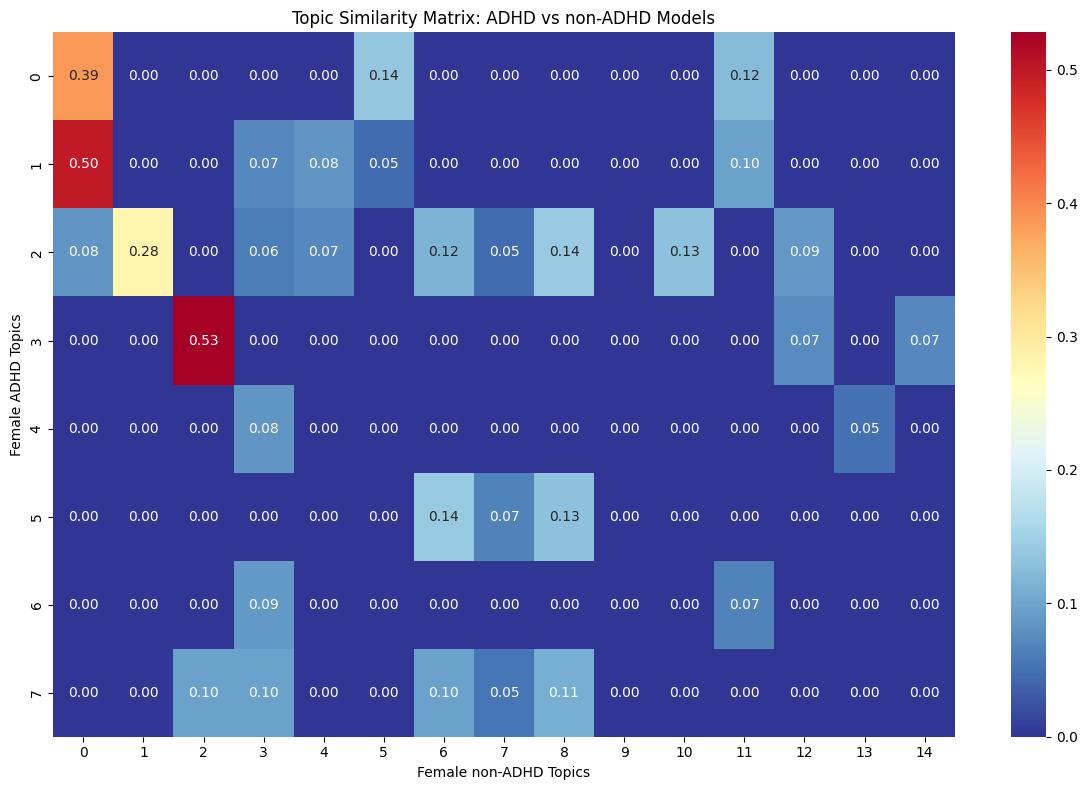

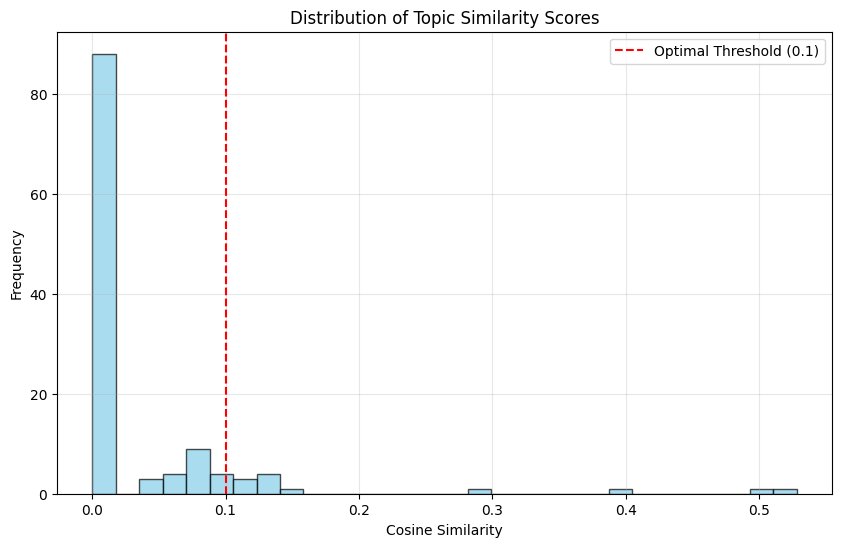

Similarity statistics:
Mean: 0.035
Median: 0.000
Std: 0.085
% above threshold (0.1): 10.0%


In [19]:
# Visualize similarity matrix
plt.figure(figsize=(12, 8))
sns.heatmap(base_sim_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            xticklabels=range(len(base_sim_matrix[0])), 
            yticklabels=range(len(base_sim_matrix)))
plt.title('Topic Similarity Matrix: ADHD vs non-ADHD Models')
plt.xlabel('Female non-ADHD Topics')
plt.ylabel('Female ADHD Topics')
plt.tight_layout()
plt.show()

# Show distribution of similarity scores
plt.figure(figsize=(10, 6))
similarities = base_sim_matrix.flatten()
plt.hist(similarities, bins=30, alpha=0.7, color='skyblue', edgecolor='black')

# Use the optimal threshold
threshold_to_show = best_threshold if 'best_threshold' in globals() else 0.10
plt.axvline(threshold_to_show, color='red', linestyle='--', 
           label=f'Optimal Threshold ({threshold_to_show})')

plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Topic Similarity Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Similarity statistics:")
print(f"Mean: {similarities.mean():.3f}")
print(f"Median: {np.median(similarities):.3f}")
print(f"Std: {similarities.std():.3f}")
print(f"% above threshold ({threshold_to_show}): {(similarities >= threshold_to_show).mean()*100:.1f}%")

### 1.2 Main Statistical Analysis (Separate Models)

Using the optimal similarity threshold, we now perform the core statistical comparison between the two independently trained topic models.

In [20]:
print("="*80)
print("MAIN STATISTICAL ANALYSIS: Female ADHD vs Female non-ADHD")
print("="*80)

# same function from threshold analysis
threshold = best_threshold if 'best_threshold' in globals() else 0.10
print(f"    Threshold: {threshold}")

A_vec, B_vec, aligned = create_aligned_vectors(
    threshold, tids_A, tids_B, matches, 
    topics_A_docs, topics_B_docs
)

print(f"\n📊 ALIGNMENT SUMMARY:")
num_pairs = sum(1 for ta, tb in aligned if ta is not None and tb is not None)
num_unique_A = sum(1 for ta, tb in aligned if tb is None and ta is not None)
num_unique_B = sum(1 for ta, tb in aligned if ta is None and tb is not None)

print(f"  - Matched pairs: {num_pairs}")
print(f"  - ADHD-unique topics: {num_unique_A}")
print(f"  - Non-ADHD-unique topics: {num_unique_B}")
print(f"  - Total topics in analysis: {len(aligned)}")
print(f"  - Total documents: ADHD={A_vec.sum()}, Non-ADHD={B_vec.sum()}")

# Perform statistical analysis
corrected_results = complete_corrected_analysis(A_vec, B_vec, ("Female ADHD", "Female non-ADHD"))

# Summary
print(f"\n" + "="*60)
print(f"FINAL RESULTS SUMMARY")
print(f"="*60)
print(f"    Effect Size: JSD = {corrected_results['jsd']:.4f} ({corrected_results['effect_interpretation']})")
print(f"    Significance: p = {corrected_results['fisher_p']:.6f} ({corrected_results['significance_interpretation']})")
print(f"    Odds Ratio: {corrected_results['odds_ratio']:.3f}")
print(f"    Conclusion: {corrected_results['overall_conclusion']}")

MAIN STATISTICAL ANALYSIS: Female ADHD vs Female non-ADHD
    Threshold: 0.1

📊 ALIGNMENT SUMMARY:
  - Matched pairs: 6
  - ADHD-unique topics: 2
  - Non-ADHD-unique topics: 9
  - Total topics in analysis: 17
  - Total documents: ADHD=59, Non-ADHD=183
CORRECTED TOPIC ANALYSIS: Female ADHD vs Female non-ADHD

📊 EFFECT SIZE:
Jensen-Shannon Divergence: 0.539
Interpretation: Very large effect

📈 DATA STRUCTURE:
Female ADHD uses 8 topics
Female non-ADHD uses 15 topics
Overlapping topics: 6
Total documents: Female ADHD=59, Female non-ADHD=183

🎯 STATISTICAL SIGNIFICANCE:
Strategy comparison table:
                Group-Specific  Shared
Female ADHD                 8      51
Female non-ADHD            59     124

Fisher's exact test:
p-value: 0.004550
Odds ratio: 0.330
Result: Very significant (p < 0.01)

🎯 CONCLUSION:
✅ STRONG EVIDENCE: Groups have substantially different topic patterns

FINAL RESULTS SUMMARY
    Effect Size: JSD = 0.5393 (Very large effect)
    Significance: p = 0.004550 (Ve

### 1.3 Topic Content Analysis

Now let's examine the actual content of aligned topics to understand what each group emphasizes:

In [21]:
rows = []
for (ta, tb), ca, cb in zip(aligned, A_vec, B_vec):
    rows.append({
        "topic_A": ta, "topic_B": tb,
        "count_A": int(ca), "count_B": int(cb)
    })
import pandas as pd
df_aligned = pd.DataFrame(rows)

In [22]:
def topic_top_words(model, tid, n=5):
    if tid is None or pd.isna(tid):
        return None
    tid = int(tid)
    pairs = model.get_topic(tid)
    if not pairs:
        return None
    return ", ".join([w for w, _ in pairs[:n]])

df_aligned["label_A"] = df_aligned["topic_A"].apply(lambda t: topic_top_words(adhd_topic_model, t))
df_aligned["label_B"] = df_aligned["topic_B"].apply(lambda t: topic_top_words(noadhd_topic_model, t))
df_aligned.head(100)

,topic_A,topic_B,count_A,count_B,label_A,label_B
0,0.0,5.0,15,8,"consigo, fazer, comecei, tempo, coisas","música, ouvir, tocar, enquanto, tanto"
1,1.0,0.0,13,45,"dia, hoje, ainda, semana, porque","dia, hoje, fazer, porque, trabalho"
2,2.0,1.0,11,37,"phda, pessoas, vida, lá, onde","pessoas, sempre, vezes, algo, sinto"
3,3.0,2.0,6,20,"mãe, memória, anos, muitas, pq","memória, lembro, anos, mãe, dizer"
4,5.0,6.0,3,8,"mundo, tão, sei explicar, ideia, explicar","viajar, novas, sentir, silêncio, mundo"
5,7.0,8.0,3,6,"áreas, tudo, interesse especial, especial, int...","caminho, inglês, fez, gostava, confusão"
6,4.0,NaN,5,0,"saúde, interesse, nesta, acompanhado, infantil",None
7,6.0,NaN,3,0,"serem, motivos, verdadeiramente, tendência, co...",None
8,NaN,3.0,0,14,None,"ler, história, músicas, livros, forma"
9,NaN,4.0,0,12,None,"cozinhar, gosto, adoro, acalma, porque"


## Analysis 2: Combined Model Permutation Test
When both groups use the same topic space, do they still use topics differently?

This approach tests whether linguistic differences persist even when groups are constrained to use the same vocabulary/topic structure.

In [23]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords", quiet=True)
portuguese_stopwords = stopwords.words("portuguese")
additional_stopwords = [
    "pra",
    "pro",
    "tá",
    "já",
    "ter",
    "vai",
    "vou",
    "então",
    "assim",
    "aí",
    "sobre"
]
portuguese_stopwords.extend(additional_stopwords)

In [24]:
def permutation_test(adhd_texts, noadhd_texts, n_permutations=1000, random_seed=42):
    """
    Fixed permutation test that creates a single combined topic model,
    then tests if group differences could arise by chance.
    
    H0: Topic distributions are the same for both groups
    H1: Topic distributions differ between groups
    """
    from bertopic import BERTopic
    from sentence_transformers import SentenceTransformer
    from umap import UMAP
    from hdbscan import HDBSCAN
    from bertopic.vectorizers import ClassTfidfTransformer
    from bertopic.representation import KeyBERTInspired
    
    rng = np.random.default_rng(random_seed)
    
    all_texts = adhd_texts + noadhd_texts
    true_labels = ['ADHD'] * len(adhd_texts) + ['noADHD'] * len(noadhd_texts)
    print(f"Creating combined topic model for {len(all_texts)} documents...")
    
    # Same setup as before
    embedding_model = SentenceTransformer("PORTULAN/serafim-900m-portuguese-pt-sentence-encoder")
    umap_model = UMAP(n_neighbors=5, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
    hdbscan_model = HDBSCAN(min_cluster_size=4, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
    vectorizer_model = CountVectorizer(stop_words=portuguese_stopwords, min_df=2, ngram_range=(1, 2))
    ctfidf_model = ClassTfidfTransformer(bm25_weighting=True)
    
    keybert_model = KeyBERTInspired()

    representation_model = {
        "KeyBERT": keybert_model,
    }
    
    combined_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_model,
        language="multilingual",
        top_n_words=10,
        verbose=True,
        calculate_probabilities=True,
        ctfidf_model=ctfidf_model,
    )
    topics_all, _ = combined_model.fit_transform(all_texts)
    

    def calculate_group_difference(group_labels, topic_assignments):
        """Calculate JSD between two groups' topic distributions"""
        adhd_mask = np.array(group_labels) == 'ADHD'
        noadhd_mask = np.array(group_labels) == 'noADHD'
        
        adhd_topics = np.array(topic_assignments)[adhd_mask]
        noadhd_topics = np.array(topic_assignments)[noadhd_mask]
        
        # Count topics for each group (excluding outliers = -1)
        adhd_counts = Counter([t for t in adhd_topics if t != -1])
        noadhd_counts = Counter([t for t in noadhd_topics if t != -1])
        
        # Get all unique topics
        all_topic_ids = set(adhd_counts.keys()) | set(noadhd_counts.keys())
        if len(all_topic_ids) < 2:
            return np.nan
        
        # Create count vectors
        adhd_vec = np.array([adhd_counts.get(tid, 0) for tid in sorted(all_topic_ids)])
        noadhd_vec = np.array([noadhd_counts.get(tid, 0) for tid in sorted(all_topic_ids)])
        
        # Calculate JSD
        if adhd_vec.sum() == 0 or noadhd_vec.sum() == 0:
            return np.nan
        
        return js_divergence(adhd_vec, noadhd_vec, base=2)
    

    jsd_observed = calculate_group_difference(true_labels, topics_all)
    print(f"Observed JSD with combined model: {jsd_observed:.4f}")
    
    # Permutation test
    print(f"Running {n_permutations} permutations...")
    perm_jsds = []
    
    for i in range(n_permutations):
        # Shuffle group labels while keeping same group sizes
        shuffled_labels = true_labels.copy()
        rng.shuffle(shuffled_labels)
        
        # Calculate JSD for shuffled groups
        jsd_perm = calculate_group_difference(shuffled_labels, topics_all)
        if not np.isnan(jsd_perm):
            perm_jsds.append(jsd_perm)
        
        if (i + 1) % 200 == 0:
            print(f"  Completed {i + 1}/{n_permutations} permutations")
    
    perm_jsds = np.array(perm_jsds)
    
    # Calculate p-value
    if len(perm_jsds) > 0:
        p_value = (perm_jsds >= jsd_observed).mean()
    else:
        p_value = np.nan
    
    return {
        'observed_jsd': jsd_observed,
        'permuted_jsds': perm_jsds,
        'p_value': p_value,
        'n_successful_permutations': len(perm_jsds),
        'combined_model': combined_model,
        'all_topic_assignments': topics_all
    }

In [25]:
adhd_texts = adhd_df_group["response"].tolist()
noadhd_texts = noadhd_df_group["response"].tolist()

print(f"Running permutation test...")
print(f"ADHD group: {len(adhd_texts)} documents")
print(f"Non-ADHD group: {len(noadhd_texts)} documents")

# Permutation test
perm_results = permutation_test(
    adhd_texts, noadhd_texts, 
    n_permutations=1000, 
    random_seed=42
)

print(f"\n=== PERMUTATION TEST RESULTS ===")
print(f"Observed JSD: {perm_results['observed_jsd']:.4f}")
print(f"Permutation p-value: {perm_results['p_value']:.4f}")
print(f"Successful permutations: {perm_results['n_successful_permutations']}/1000")

# Interpretation
if perm_results['p_value'] < 0.05:
    print(f"\nSIGNIFICANT: p < 0.05")
    print(f"   → The observed difference is NOT due to random chance")
    print(f"   → Groups really do have different topic distributions")
else:
    print(f"\nNOT SIGNIFICANT: p >= 0.05") 
    print(f"   → The observed difference could be due to random chance")
    print(f"   → No strong evidence of real group differences")

Running permutation test...
ADHD group: 65 documents
Non-ADHD group: 220 documents
Creating combined topic model for 285 documents...


2025-08-28 22:09:19,872 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2025-08-28 22:11:04,508 - BERTopic - Embedding - Completed ✓
2025-08-28 22:11:04,509 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-28 22:11:04,509 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-28 22:11:11,248 - BERTopic - Dimensionality - Completed ✓
2025-08-28 22:11:11,249 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-28 22:11:11,248 - BERTopic - Dimensionality - Completed ✓
2025-08-28 22:11:11,249 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-28 22:11:11,262 - BERTopic - Cluster - Completed ✓
2025-08-28 22:11:11,264 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-28 22:11:11,262 - BERTopic - Cluster - Completed ✓
2025-08-28 22:11:11,264 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-28 22:13:08,373 - BERTopic - Representation - Completed ✓
2025-08-28 22:13:08,373 - BERTopic - Repres

Observed JSD with combined model: 0.0901
Running 1000 permutations...
  Completed 200/1000 permutations
  Completed 400/1000 permutations
  Completed 600/1000 permutations
  Completed 800/1000 permutations
  Completed 1000/1000 permutations

=== PERMUTATION TEST RESULTS ===
Observed JSD: 0.0901
Permutation p-value: 0.1200
Successful permutations: 1000/1000

NOT SIGNIFICANT: p >= 0.05
   → The observed difference could be due to random chance
   → No strong evidence of real group differences


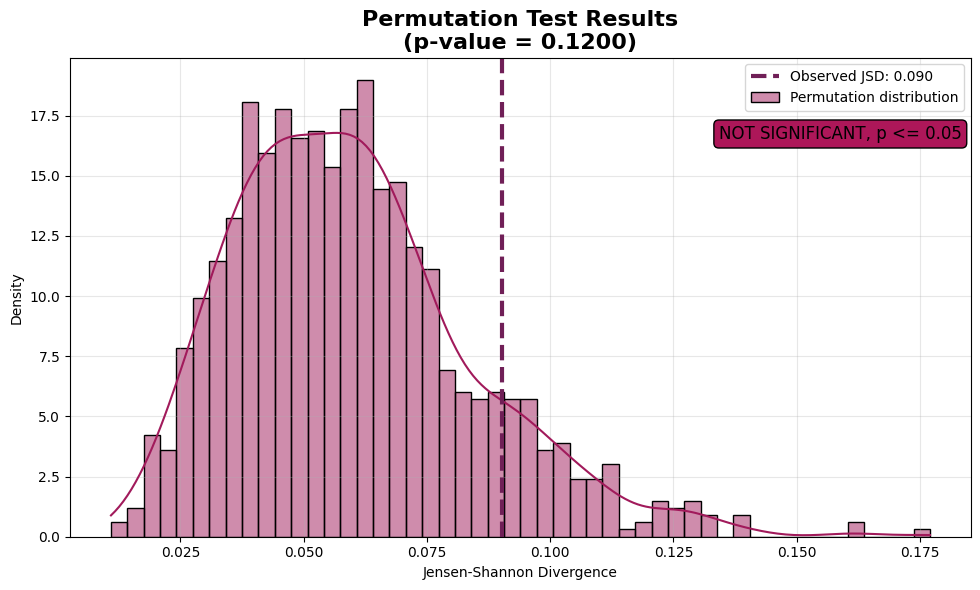


=== PERMUTATION STATISTICS ===
Mean of null distribution: 0.0598
Std of null distribution: 0.0242
95th percentile of null: 0.1046
99th percentile of null: 0.1285


In [26]:
import seaborn as sns

if perm_results['n_successful_permutations'] > 0:   
    plt.figure(figsize=(10, 6))
    
    # Use seaborn for histogram
    sns.histplot(perm_results['permuted_jsds'], bins=50, kde=True, 
                 color=sns.color_palette("rocket", as_cmap=True)(0.4), 
                 label='Permutation distribution', stat='density')
    
    # Mark the observed value
    plt.axvline(perm_results['observed_jsd'], color=sns.color_palette("rocket")[1], 
                linestyle='--', linewidth=3, 
                label=f'Observed JSD: {perm_results["observed_jsd"]:.3f}')
    
    plt.xlabel('Jensen-Shannon Divergence')
    plt.ylabel('Density')
    plt.title(f'Permutation Test Results\n(p-value = {perm_results["p_value"]:.4f})',
              fontsize=16, fontweight='bold', color='black')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add text annotation
    if perm_results['p_value'] <= 0.05:
        plt.text(0.885, 0.83, 'SIGNIFICANT, p > 0.05', 
                transform=plt.gca().transAxes, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor=sns.color_palette("rocket")[2]),
                fontsize=12, ha='center')
    else:
        plt.text(0.855, 0.83, 'NOT SIGNIFICANT, p <= 0.05', 
                transform=plt.gca().transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor=sns.color_palette("rocket")[2]),
                fontsize=12, ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Additional statistics
    print(f"\n=== PERMUTATION STATISTICS ===")
    print(f"Mean of null distribution: {perm_results['permuted_jsds'].mean():.4f}")
    print(f"Std of null distribution: {perm_results['permuted_jsds'].std():.4f}")
    print(f"95th percentile of null: {np.percentile(perm_results['permuted_jsds'], 95):.4f}")
    print(f"99th percentile of null: {np.percentile(perm_results['permuted_jsds'], 99):.4f}")
else:
    print("No successful permutations to visualize!")

## Bootstrap Analysis

In [27]:
rng = np.random.default_rng(42)
B = 1000
boot_jsd = []

# Get original alignment
cntA_orig = counts_per_topic(topics_A_docs)
cntB_orig = counts_per_topic(topics_B_docs)

for b in range(B):
    # Resample document assignments, not alignments
    idxA = rng.integers(0, len(topics_A_docs), len(topics_A_docs))
    idxB = rng.integers(0, len(topics_B_docs), len(topics_B_docs))
    
    # Use the SAME alignment, but with resampled topic assignments
    resampled_A_topics = np.array(topics_A_docs)[idxA]
    resampled_B_topics = np.array(topics_B_docs)[idxB]
    
    # Count topics for resampled data
    cntA_resamp = counts_per_topic(resampled_A_topics)
    cntB_resamp = counts_per_topic(resampled_B_topics)
    
    # Use the ORIGINAL alignment structure with resampled counts
    A_vec_b, B_vec_b = [], []
    for ta, tb in aligned:  # ← Use the original 'aligned' from earlier
        A_vec_b.append(cntA_resamp.get(ta, 0) if ta is not None else 0)
        B_vec_b.append(cntB_resamp.get(tb, 0) if tb is not None else 0)
    
    try:
        # Only calculate JSD for bootstrap
        A_vec_b = np.array(A_vec_b)
        B_vec_b = np.array(B_vec_b)
        
        if A_vec_b.sum() > 0 and B_vec_b.sum() > 0:
            jsd_b = js_divergence(A_vec_b, B_vec_b, base=2)
            boot_jsd.append(jsd_b)
    except ValueError:
        continue

In [28]:
# Calculate confidence intervals and interpret results
if len(boot_jsd) > 0:
    boot_jsd = np.array(boot_jsd)
    
    jsd_ci_lower = np.percentile(boot_jsd, 2.5)
    jsd_ci_upper = np.percentile(boot_jsd, 97.5)
    
    print(f"\nBootstrap 95% Confidence Intervals:")
    print(f"JSD: [{jsd_ci_lower:.4f}, {jsd_ci_upper:.4f}]")
    
    print(f"\nOriginal vs Bootstrap comparison:")
    original_jsd = corrected_results['jsd']
    print(f"Original JSD: {original_jsd:.4f} (bootstrap mean: {boot_jsd.mean():.4f})")
    
    # Effect size interpretation for JSD
    print(f"\nJSD Interpretation (higher = more different):")
    if original_jsd < 0.1:
        print("- Very similar topic distributions")
    elif original_jsd < 0.3:
        print("- Moderately different topic distributions")
    elif original_jsd < 0.5:
        print("- Substantially different topic distributions")
    else:
        print("- Very different topic distributions")
else:
    print("No valid bootstrap samples were generated!")
    
# Check if we have sufficient successful bootstrap samples
success_rate = len(boot_jsd) / B
print(f"\nBootstrap success rate: {success_rate:.1%} ({len(boot_jsd)}/{B} samples)")
if success_rate < 0.8:
    print("Warning: Low bootstrap success rate may indicate issues with the resampling approach")


Bootstrap 95% Confidence Intervals:
JSD: [0.2388, 0.3979]

Original vs Bootstrap comparison:
Original JSD: 0.5393 (bootstrap mean: 0.3127)

JSD Interpretation (higher = more different):
- Very different topic distributions

Bootstrap success rate: 100.0% (1000/1000 samples)
